## Advanced Lane Finding Project
# Test image pipeline
The goals / steps of this project are the following:

* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [18]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#import PyQt5
%matplotlib qt
import pickle
import os.path
%matplotlib inline

# load pickled distortion matrix
with open('wide_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

## Apply the correction to test images

In [19]:
images = glob.glob('test_images/*.jpg')
undist_images = []
# Test undistortion for each image
for fname in images:
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    undist_images.append(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    
    # split fname for output
    outfname, ext = os.path.splitext(fname.split('/')[-1])
    # output undist img with _undist.jpg
    cv2.imwrite('output_images/undst_test_images/{0}_undist.jpg'.format(outfname),undist)

Text(0.5,1,'Undistorted Image')

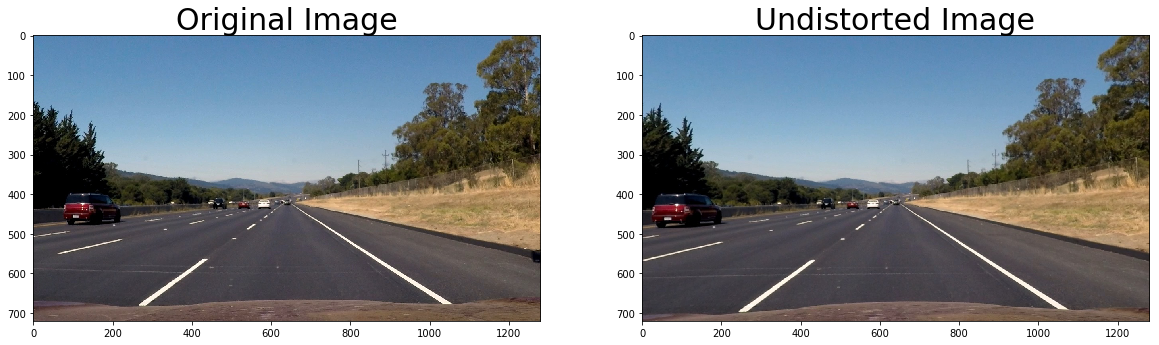

In [20]:
num_image = 6
img = cv2.imread(images[num_image])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = undist_images[num_image]

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [21]:
import matplotlib.image as mpimg

#images = glob.glob('test_images/*.jpg')
#image = mpimg.imread(images[1])
images = undist_images

color_binary_images = []
combined_binary_images = []

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

for image in images:
    #image = mpimg.imread(fname)
    color_binary, combined_binary = pipeline(image, (170, 255), (20, 100))
    
    # split fname for output
    #outfname, ext = os.path.splitext(fname.split('/')[-1])
    #plt.imsave('output_images/binary_images/{0}_binary.jpg'.format(outfname),combined_binary,cmap = 'gray')
    color_binary_images.append(color_binary)
    combined_binary_images.append(combined_binary)

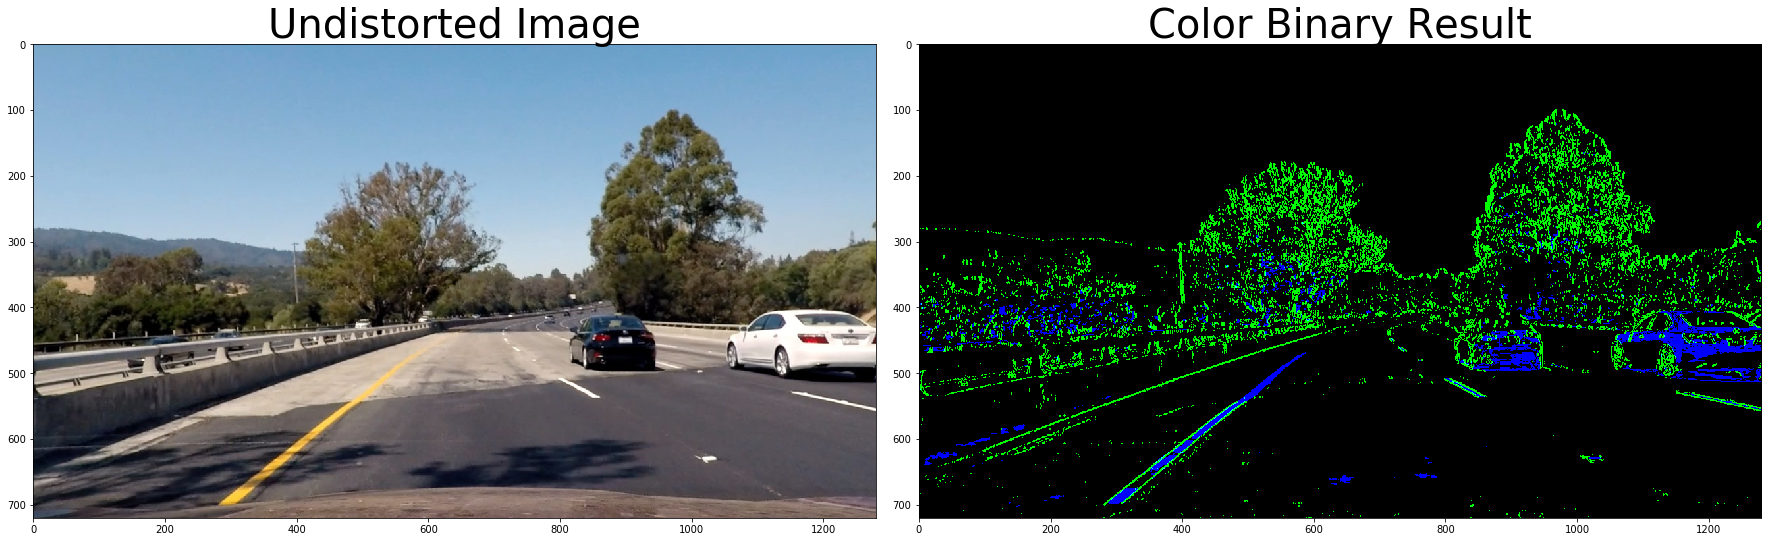

In [22]:
# Plot the result
num_image = 2

img = undist_images[num_image]
color_binary = color_binary_images[num_image]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Undistorted Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Color Binary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

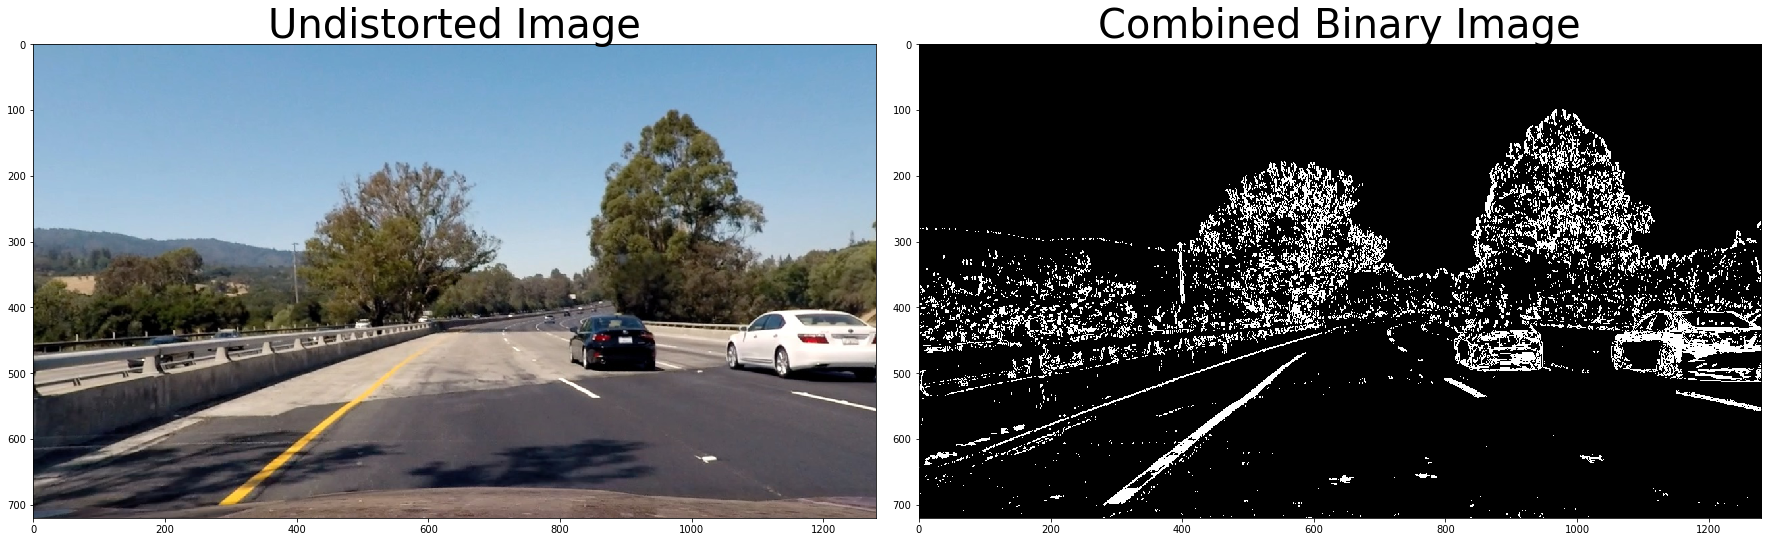

In [23]:
combined_binary = combined_binary_images[num_image]

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Undistorted Image', fontsize=40)

ax2.imshow(combined_binary,cmap = 'gray')
ax2.set_title('Combined Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#plt.imsave('output_images/binary_images/{0}_binary.jpg'.format(num_image),combined_binary,cmap = 'gray')

## Perspective transofrm

In [24]:
# Define src position and dst position
#src = np.float32(
#        [[img_size[0]/2 - 55, img_size[1]/2 + 100],
#         [img_size[0]/6 - 10, img_size[1]],
#         [img_size[0]*5/6 + 60, img_size[1]],
#         [img_size[0]/2 + 55, img_size[1]/2 + 100]])

src = np.float32(
        [[img_size[0]/2 - 60, img_size[1]/2 + 100],
         [img_size[0]/6 - 25, img_size[1]],
         [img_size[0]*5/6 + 75, img_size[1]],
         [img_size[0]/2 + 60, img_size[1]/2 + 100]])

dst = np.float32(
        [[img_size[0]/4, 0],
         [img_size[0]/4, img_size[1]],
         [img_size[0]*3/4, img_size[1]],
         [img_size[0]*3/4, 0]])

In [25]:
# Get M and Minv for transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Define perspective transform function
def warper(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    #M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size,cv2.INTER_NEAREST)
    return warped

In [26]:
binary_warped_images = []
for image in combined_binary_images:
    binary_warped_image = warper(image, src, dst)
    binary_warped_images.append(binary_warped_image)

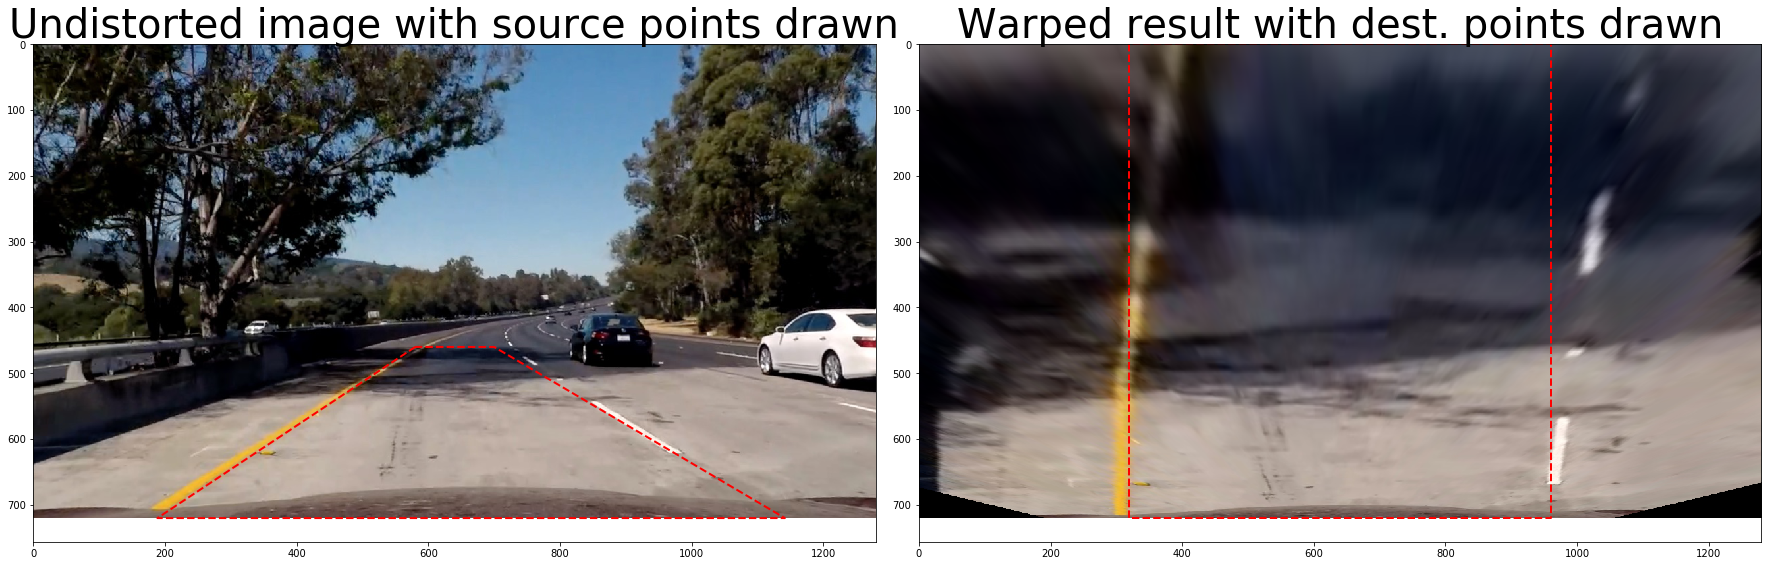

In [69]:
# Plot the result
num_image = 1
image = undist_images[num_image]
warped_image = warper(image, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image, cmap = 'gray')
x = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]
ax1.plot(x, y, 'r--', lw=2)
ax1.set_title('Undistorted image with source points drawn', fontsize=40)

ax2.imshow(warped_image)
x = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]
ax2.plot(x, y, 'r--', lw=2)
ax2.set_title('Warped result with dest. points drawn', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#plt.imsave('output_images/perspective_transform_images/{0}_warped.jpg'.format(num_image),warped_image)

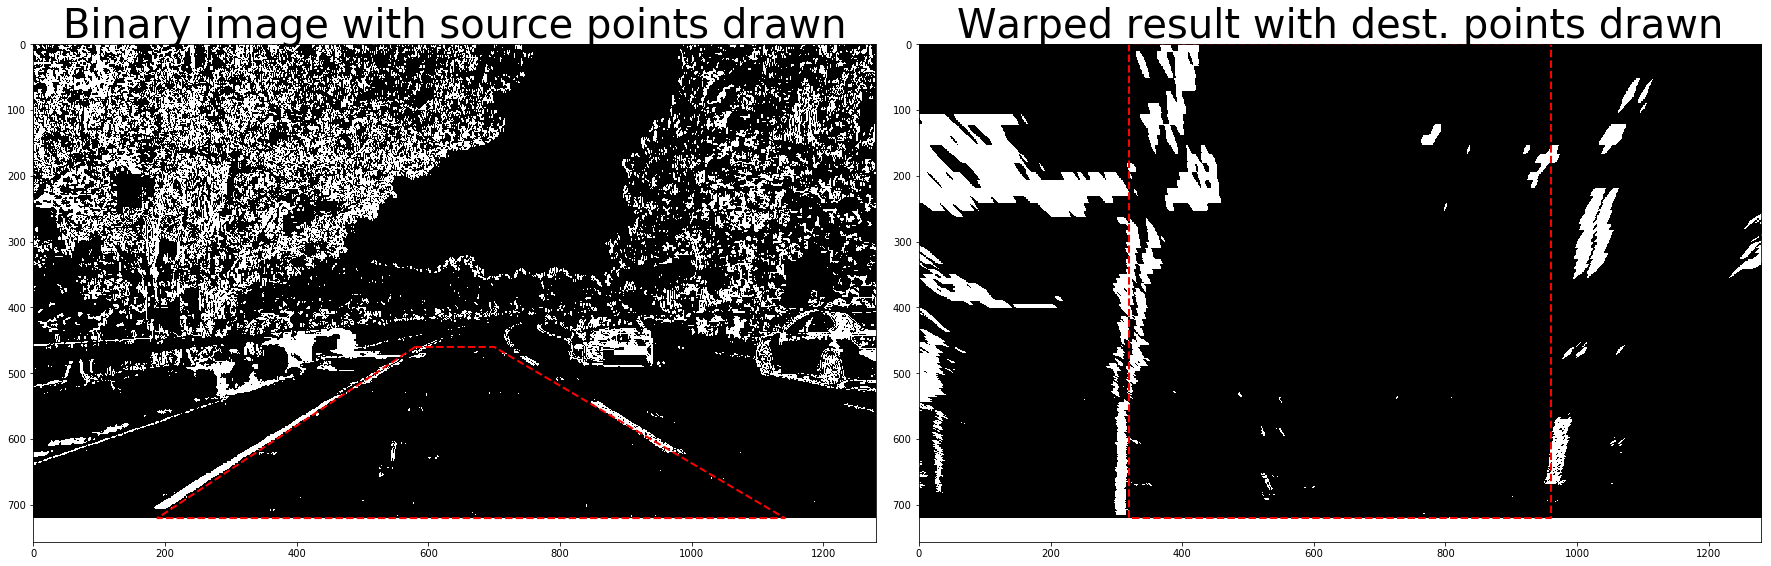

In [70]:
image = combined_binary_images[num_image]
binary_warped_image = binary_warped_images[num_image]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image, cmap = 'gray')
x = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]
ax1.plot(x, y, 'r--', lw=2)
ax1.set_title('Binary image with source points drawn', fontsize=40)

ax2.imshow(binary_warped_image, cmap = 'gray')
x = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]
ax2.plot(x, y, 'r--', lw=2)
ax2.set_title('Warped result with dest. points drawn', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary

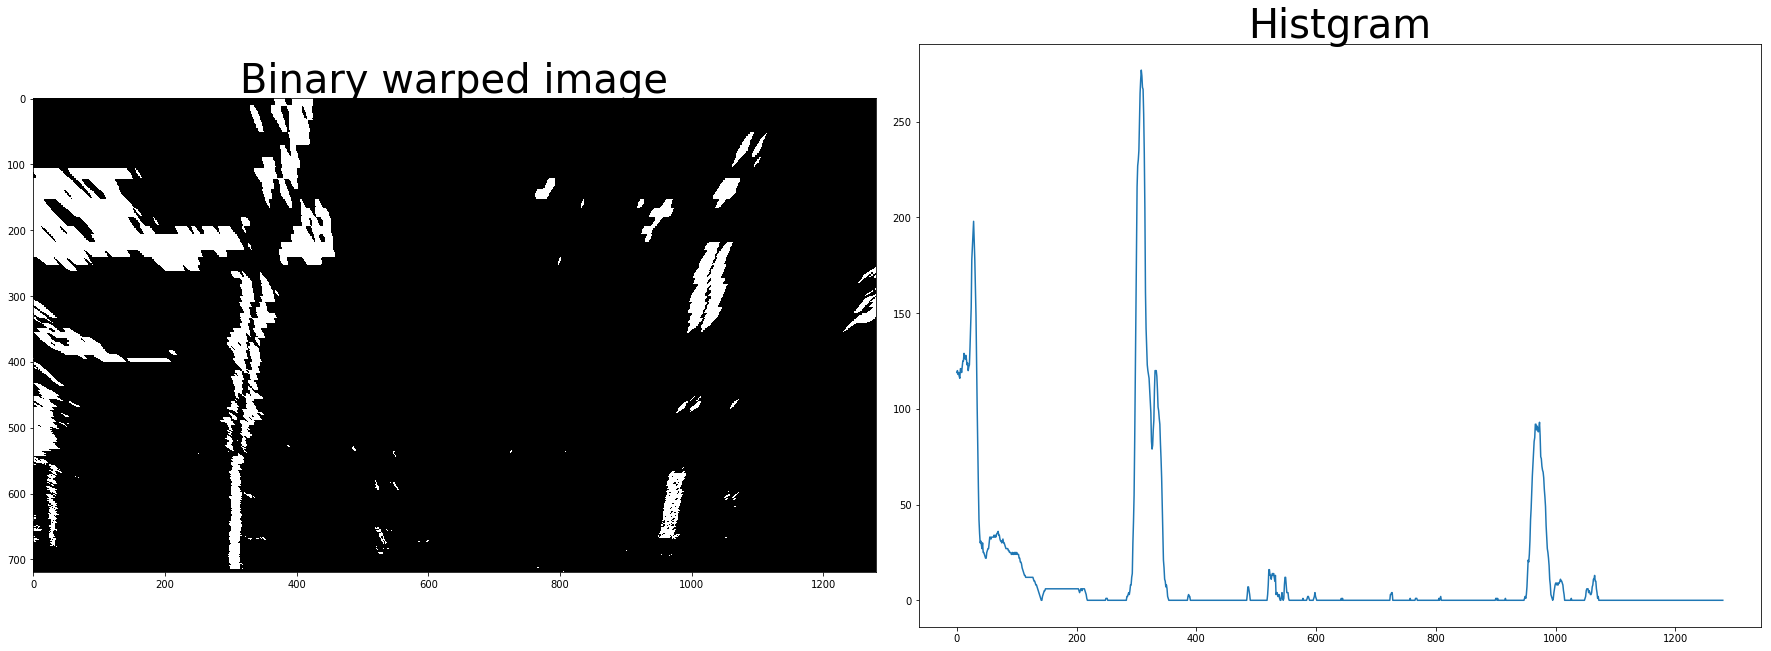

In [72]:
num_image = 1
img = binary_warped_images[num_image]
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img,cmap='gray')
ax1.set_title('Binary warped image', fontsize=40)

#ax2.imshow(histogram)
ax2.plot(histogram)
ax2.set_title('Histgram', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [73]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
num_image = 1
binary_warped = binary_warped_images[num_image]
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 70
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [74]:
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

In [75]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

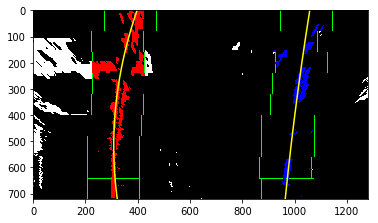

In [76]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# add center
center_fitx = (left_fitx + right_fitx) / 2.0

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.plot(center_fitx, ploty, 'y--')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [77]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

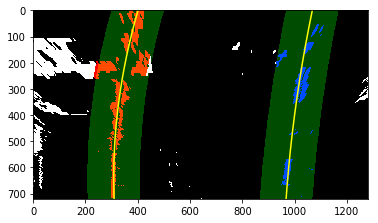

In [79]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Determine the curvature of the lane and vehicle position with respect to center.

In [81]:
y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
center_fit_cr = np.polyfit(ploty*ym_per_pix, center_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
center_curverad = ((1 + (2*center_fit_cr[0]*y_eval*ym_per_pix + center_fit_cr[1])**2)**1.5) / np.absolute(2*center_fit_cr[0])
# Now our radius of curvature is in meters
#print(left_curverad, 'm', center_curverad, 'm', right_curverad, 'm')
print('Radius of carvature = {0} m'.format(int(center_curverad)))

# cal car offset
car_offset = (center_fitx[-1] - midpoint) * xm_per_pix
if car_offset < 0:
    print('Vehicle is {0:.2} m left of center'.format(np.absolute(car_offset)))
else:
    print('Vehicle is {0:.2} m right of center'.format(np.absolute(car_offset)))

Radius of carvature = 884 m
Vehicle is 0.015 m right of center


In [82]:
#Minv = cv2.getPerspectiveTransform(dst, src)
def project_lane_lines(undstimg,left_fitx,right_fitx,yvals,Minv):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undstimg).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    #undist = undistort(img)    
    #unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undstimg.shape[1], undstimg.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undstimg, 1, newwarp, 0.3, 0)
    return result

In [83]:
projectedimg = project_lane_lines(undist_images[num_image],left_fitx,right_fitx,ploty,Minv)

In [84]:
def draw_info(img, center_curverad, car_offset):
    new_img = np.copy(img)
    img_h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of carvature : ' + '{:04.2f}'.format(center_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    direction = ''
    if car_offset > 0:
        direction = 'right'
    elif car_offset < 0:
        direction = 'left'
        
    abs_center_dist = abs(car_offset)
    #text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    text = 'Vehicle is ' + '{0:.2}'.format(np.absolute(car_offset)) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [85]:
projectedimg = draw_info(projectedimg, center_curverad, car_offset)

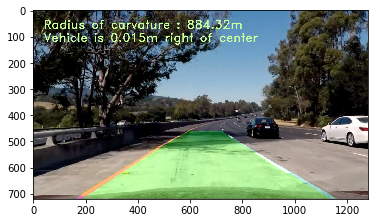

In [86]:
plt.imshow(projectedimg)

In [87]:
#plt.imsave('output_images/projected/{0}_projected.jpg'.format(num_image),projectedimg)